## はじめに

取り扱うデータが高次元になると次元の呪いと呼ばれる問題が生じることが広く知られています．
この次元の呪いが示す問題は, 使用される文脈に応じて様々であると思います．
ここでは，KD木[@wiki:Kd木]を用いた近傍探索における問題について考察します．

## やったこと

* データの次元が高くなるにつれてKD木による近傍探索の効率が低下することを実験的に検証
* 高次元データの特徴からKD木の探索が非効率的になる原因を考察

## KD木による近傍探索
ここでは，KD木を用いた近傍探索について考えます．KD木は軸並行な超平面を分離平面として，探索空間を再帰的に二つの超矩形に分割します．
従って，近傍探索は根からクエリが存在する側の超矩形を選択する深さ優先探索によって実現します．

選ばれなかった側の超矩形に対する探索は，**現在の最近傍までの距離$r_q$が，クエリから分離平面までの距離$r_d$より小さい場合（最近傍がクエリから半径$r_d$の超球内に存在）**は省略することができます．これは，分離平面の向こう側には現状の最近傍よりも良いデータは存在しないためです．この性質により，KD木を用いることで探索範囲を狭めることができます．

## 次元の変化に対する近傍探索のパフォーマンス検証

データ数Nを32768, データ次元Dを$1 \dots 1024$まで変化させた時，線形探索およびKD木による最近傍点探索に必要な時間を測定しました．
データのサンプルとクエリは，各次元の値が$[0.0 \dots 1.0]$に一様に分布する乱数としました．

以下に上述の測定を行うコードとその結果を示します．

In [86]:
import numpy as np
import timeit
from scipy.spatial import KDTree


N = 32768
n = 32

result = []
for i in range(11):
    D = 2 ** i
    heystack = np.random.random((N,D))
    kd_tree = KDTree(heystack)
    needle = np.random.random(D)
    
    flat_scan = lambda:np.argmin(np.linalg.norm(heystack - needle, axis=1))
    kd_tree_search = lambda: kd_tree.query(needle)
    
    flat_scan_time = timeit.timeit(flat_scan, number=n) / n
    kd_tree_time = timeit.timeit(kd_tree_search, number=n) / n
    result.append((flat_scan_time, kd_tree_time))
result = np.array(result)

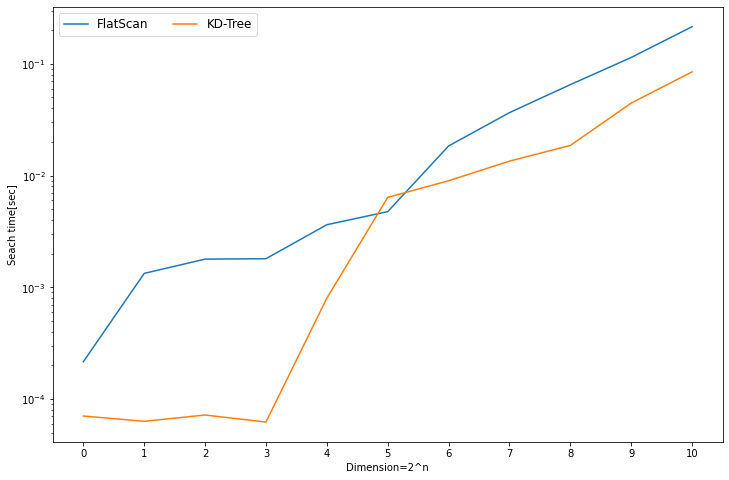

In [98]:
#| echo: false
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(r, label=["FlatScan","KD-Tree"])
plt.xticks(range(11))
plt.xlabel("Dimension=2^n")
plt.ylabel("Seach time[sec]")
plt.yscale("log")
plt.legend(fontsize='large', ncol=2)
plt.show()

上図からデータの次元が高くなるにつれて，線形探索とKD木による探索との探索時間の差が小さくなっていることが確認できます．
このことから，高次元データに対してはKD木が上手く機能していないことがわかります．

## 高次元データの性質

d次元における1辺の長さが$2r$の超立方体と半径$r$の超球の体積をそれぞれ$V_C\left(d\right)$および$V_S\left(d\right)$とします．するとこれらは以下のように表されます．

$$
\begin{aligned}
V_C\left(d\right) &= \left(2r\right)^{d} \\
V_S\left(d\right) &= \frac{r^{d}\pi^{\frac{d}{2}}}{\frac{d}{2}\Gamma\left(\frac{d}{2}\right)}
\end{aligned}
$$

次にこれらの比$\frac{V_S}{V_C}$を考えます．

$$
\begin{aligned}
\frac{V_S\left(d\right)}{V_C\left(d\right)} &= \frac{\frac{r^{d}\pi^{\frac{d}{2}}}{\frac{d}{2}\Gamma\left(\frac{d}{2}\right)}}{ \left(2r\right)^{d}}\\
&= \left(\frac{\sqrt{\pi}}{2}\right)^{d}\frac{1}{\frac{d}{2}\Gamma\left(\frac{d}{2}\right)}
\end{aligned}
$$

ここで

$$
\begin{aligned}
\frac{\pi}{2} &\simeq 0.886\\
& \lt 1
\end{aligned}
$$

となるので，

$$
\begin{aligned}
\lim_{d \rightarrow \infty} \frac{V_S\left(d\right)}{V_C\left(d\right)} &= 0
\end{aligned}
$$

となります．　また，実際に$\frac{V_S\left(d\right)}{V_C\left(d\right)}$を計算した結果を以下に示します．この結果より，$\frac{V_S\left(d\right)}{V_C\left(d\right)}$は高速に$0$へ収束することが確認できます．

In [131]:
import math
from scipy.special import gamma
import pandas as pd

def vs_over_vc(d: int) -> float:
    return ((math.sqrt(math.pi) / 2) ** d) / gamma(d / 2 + 1)

pd.DataFrame([(i, vs_over_vc(i)) for i in range(1, 10)], columns=["d", "vs/vc"]).set_index("d")

,vs/vc
d,
1,1.000000
2,0.785398
3,0.523599
4,0.308425
5,0.164493
6,0.080746
7,0.036912
8,0.015854
9,0.006442


次に，KD木において探索領域が1辺の長さが$2r_d$の超立方体に区切られ，クエリがその中心に位置する場合を考えます．
ここで，データは探索領域中に一様に分布するものとします．すると，クエリを中心とした半径$r_d$の超球内にデータが存在する確率は$\frac{V_S\left(d\right)}{V_C\left(d\right)} $となります．この値はデータの次元が高くなるほど小さくなります．したがって、高次元データにおいては，クエリを中心とした半径$r_d$の超球内にはほとんどデータが存在せず，大多数は超立方体の角に存在すると考えられます．


また，上述の結果について超立方体の対角線に着目すると非常に面白い性質を確認できます．ここで，d次元における１辺の長さが$r$である超立方体の対角線の長さ$d_{d}\left(r\right)$を考えます．この$d_{d}\left(r\right)$は以下の様に求めることができます．

$$
\begin{aligned}
d_{d}\left(r\right) &= \sqrt{\sum^{d}r^{2}}\\
&= \sqrt{d}r
\end{aligned}
$$

以上の結果より，$d$次元の超立方体の対角線の長さは$\sqrt{d}$に比例して大きくなることがわかります．これは，データの大多数が超立方体の角に存在するという前述の結果とも一致します．この性質について非常に興味深い図があったので紹介します[@15-496/15-859X]．



![class](../assets/img/2022-02-16-kdtree-and-curse-of-dimensionality/relationship_sphere_and_cube.png "2次元，　４次元，$d$次元における超球と超立方体との関係．(d/2)^(1/2)は誤りです．正しくはd^(1/2)/2")


上図は左から，2次元，4次元，$d$次元における超立方体と超球との関係のイメージです．$d_{2}\left(1\right) = \sqrt{2}$であることから，超立方体が超球に内包されています．また$d_{4}\left(1\right) = 2$であることから，超立方体が超球に内接しています．同様に$d_{d}\left(1\right)=\sqrt{d}$であることから，超立方体の角が超球の外へ飛び出しています．

この図はあくまでもイメージです．従って実際の高次元空間はこんなにも単純ではないのかもしれません．しかしながら， **低次元では超球に内包されていた超立方体が
高次元ではその角が超球をはみ出してしまう** という性質は直感に反しており非常に興味深いと思いました．


先に述べた通り，KD木による高速な近傍探索は最近傍がクエリから半径$r_d$の超球内に存在する場合に探索を省略することができるためでした．従って，この条件が成立しない高次元データでは探索を省略することはできません．この結果，KD木による探索の効率はデータの次元が高くなるにつれて低下します．

## 参考文献
::: {#refs}
:::